# CS4035 - Cyber Data Analytics
## Lab 2 - PCA/Regression task

## Group Number : 21

## Student 2
### Name : Michał Okoń
### ID :

In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import ccf

In [162]:
# If this cell does not work try running ``

import io
import nbformat

nb = nbformat.read("Lab2-PCA-Regression.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 203


## 0. Data Loading

#### Loading into pandas dataframe

In [ ]:
train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
val_data_path = os.path.join(os.getcwd(), "data", "val_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
val_data_df = pd.read_csv(val_data_path)
val_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

In [ ]:
# Excluding the time frame and the target variable
relevant_train_data_df = train_data_df.iloc[:, 1:-1]
relevant_train_data_df

In [ ]:
test_data_df

## 3. PCA task – 1/2 A4 – Individual

### 3a. Plot PCA residuals

Main functions used to perform the PCA and plot the residuals.

In [167]:
def get_pca_residuals(df, component_range = range(1, 50)):
    total_residuals = []
    for n_components in component_range:
        pca = PCA(n_components=n_components)
        pca.fit(df)
        data_pca = pca.transform(df)
        # Calculate residuals
        residuals = df - pca.inverse_transform(data_pca)
        total_residuals.append(residuals)
    return total_residuals

def plot_pca_residuals(residuals, components=None, start_index=0, true_labels = None, predicted_labels = None):
    plt.clf()
    x = np.arange(start_index, len(residuals[0]))
    for i, residual in enumerate(residuals):
        for residual_column in residual:
            plt.plot(x, residual[residual_column][start_index:], label=residual)
        if components is not None:
            plt.title(f"Residuals of PCA with n_components={components[i]}")
        else:
            plt.title(f"Residuals of PCA with n_components={i+1}")
        if true_labels is not None:
            plt.vlines(true_labels, ymin=-2, ymax=2, colors='r', linestyles='dashed')
        if predicted_labels is not None:
            plt.vlines(predicted_labels, ymin=-1, ymax=1, colors='b', linestyles='dashed')
        plt.show()

Perform the residual analysis.

In [168]:
residuals = get_pca_residuals(relevant_train_data_df)

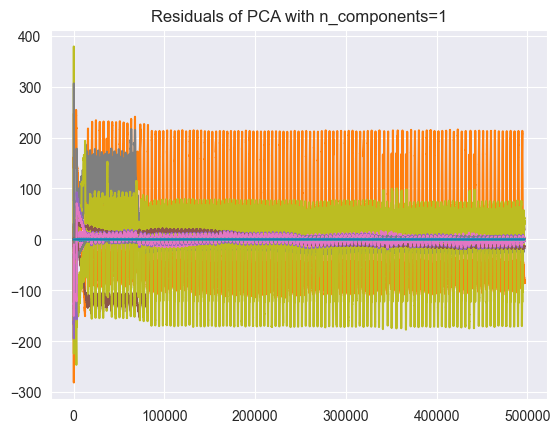

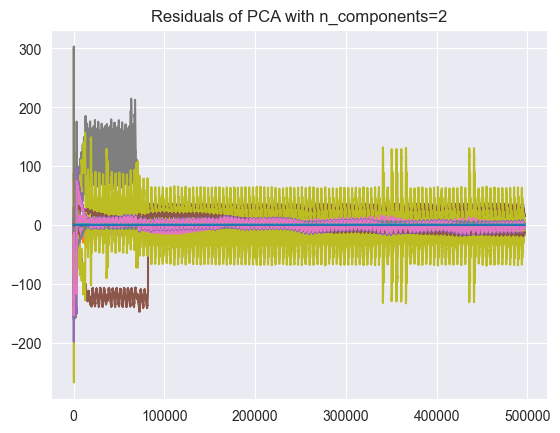

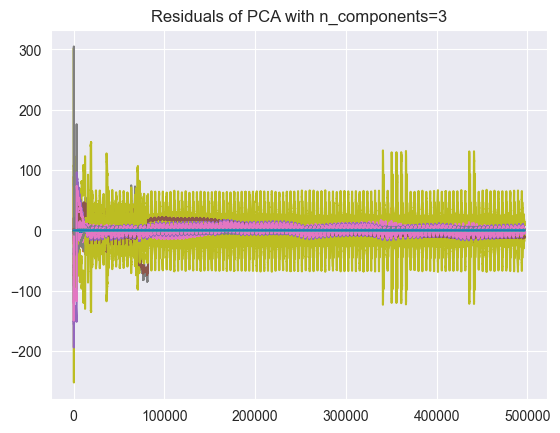

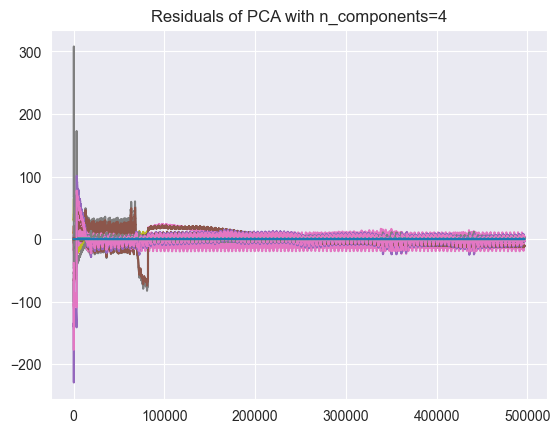

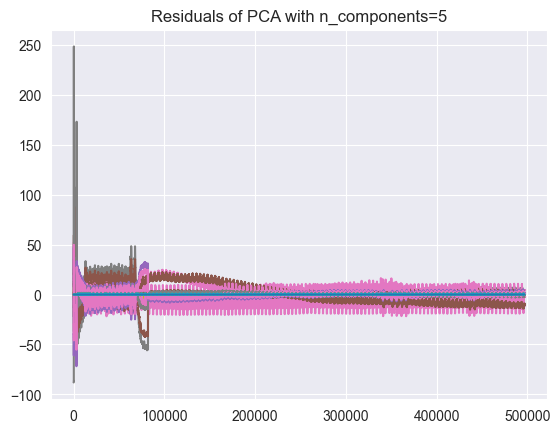

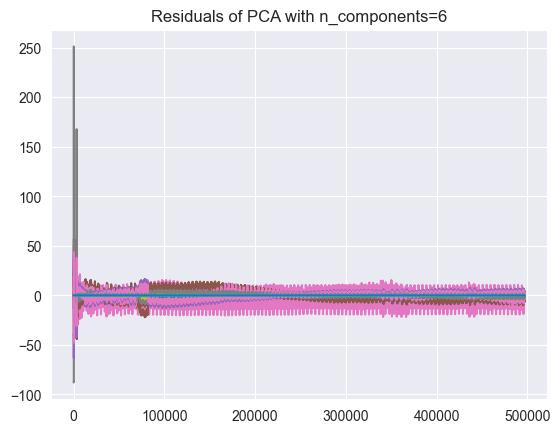

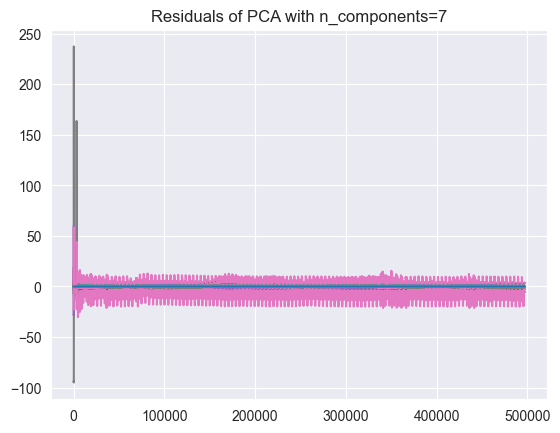

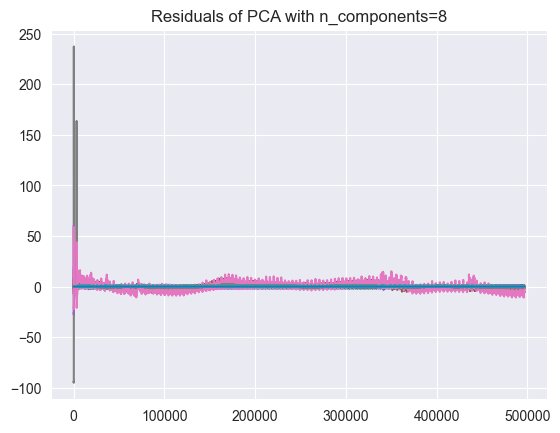

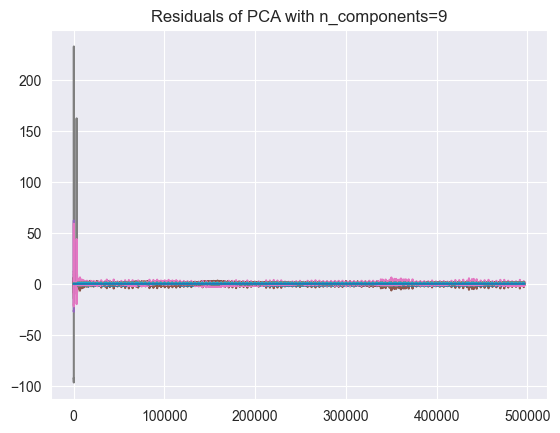

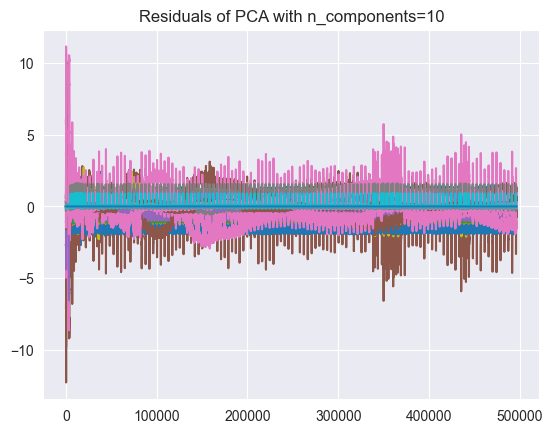

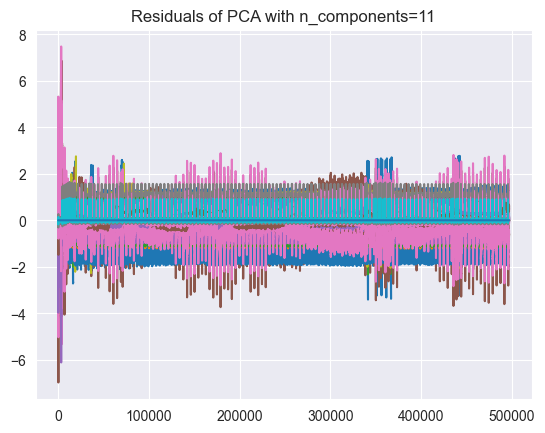

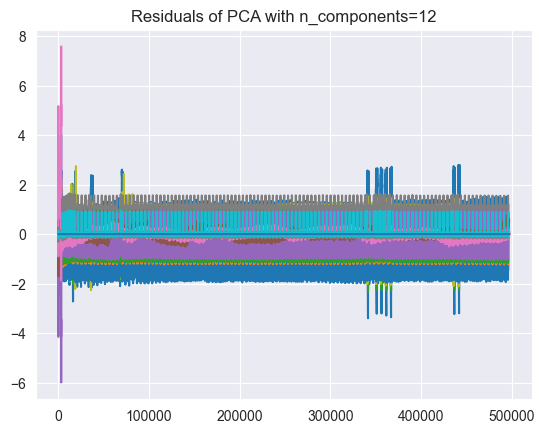

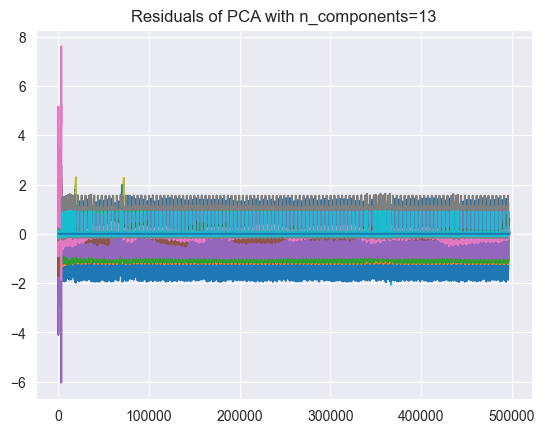

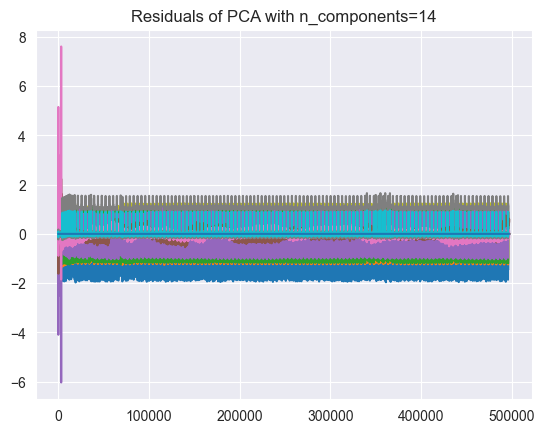

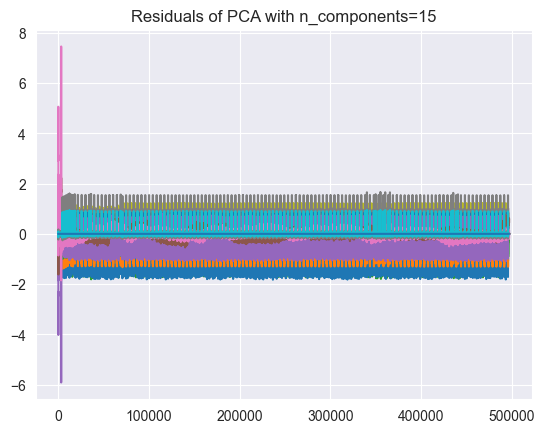

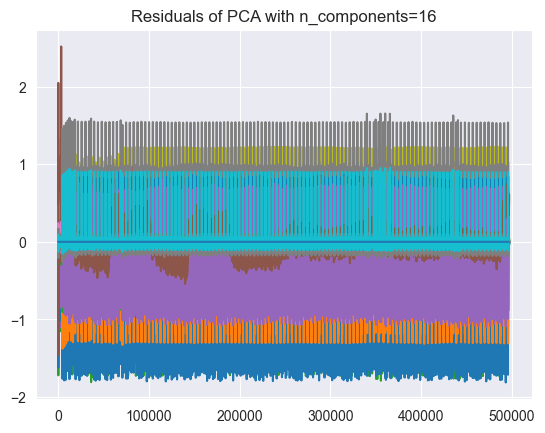

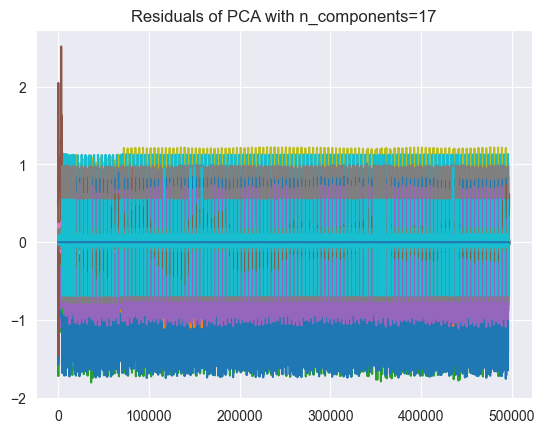

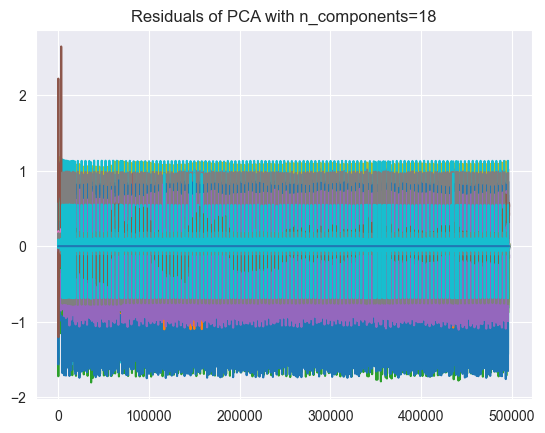

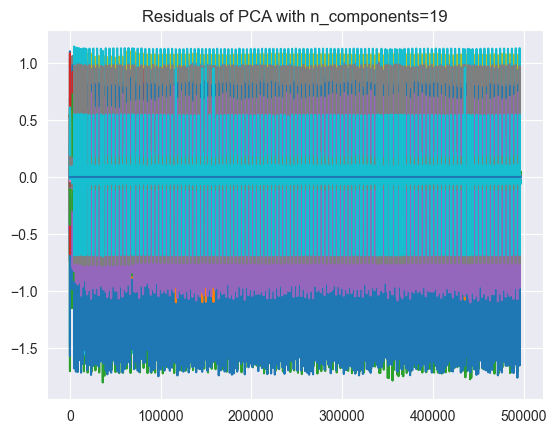

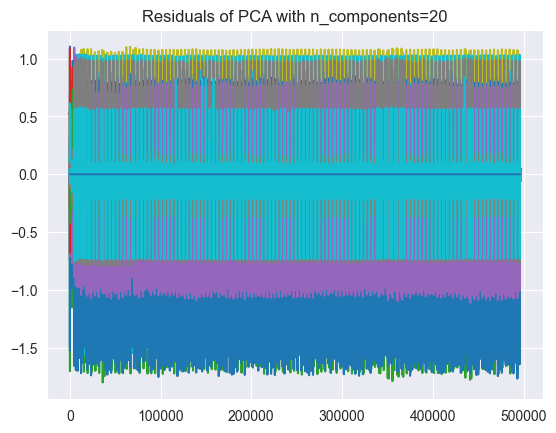

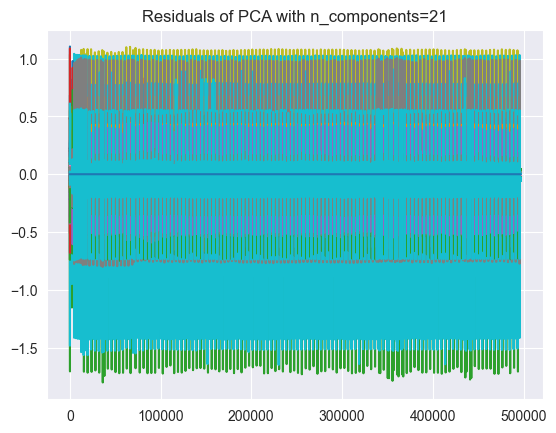

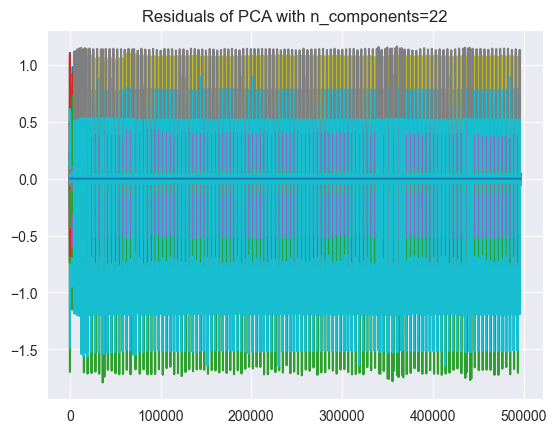

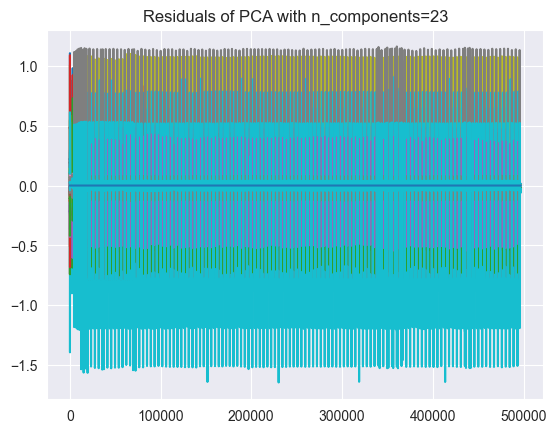

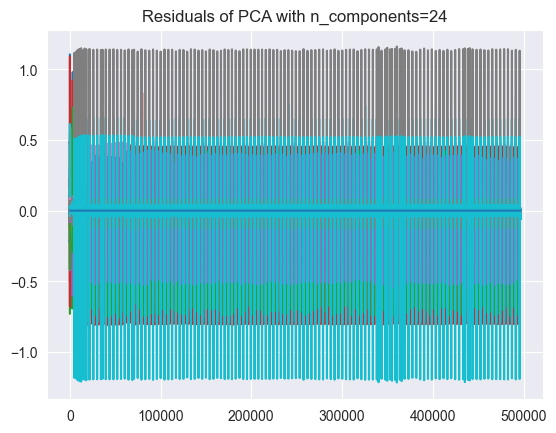

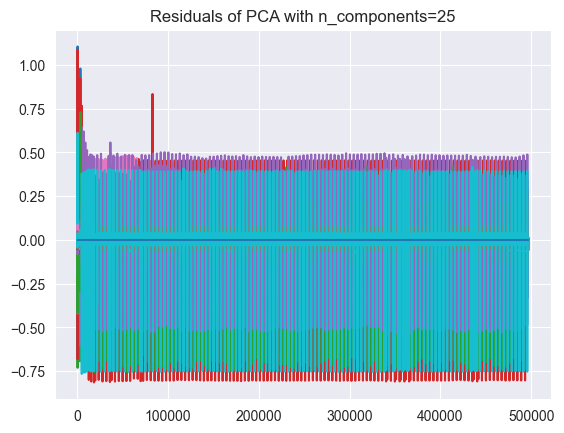

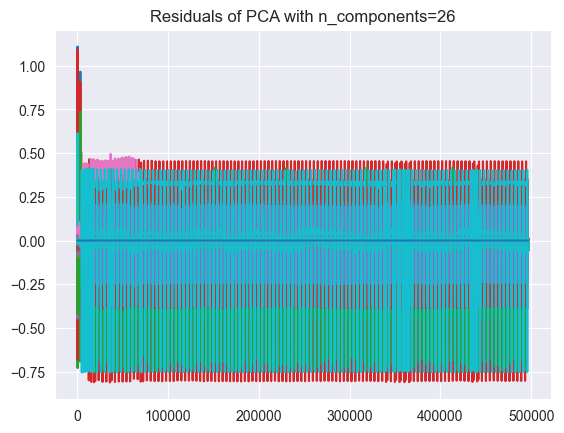

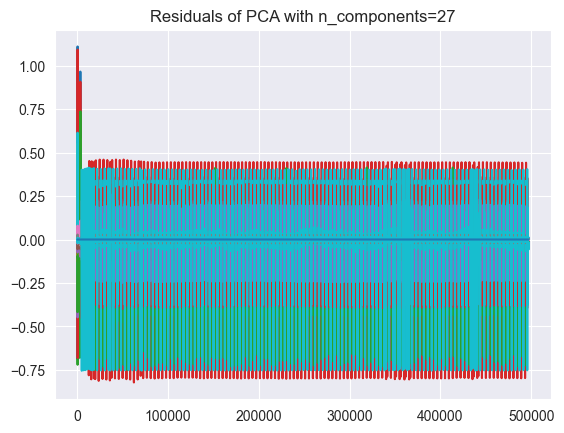

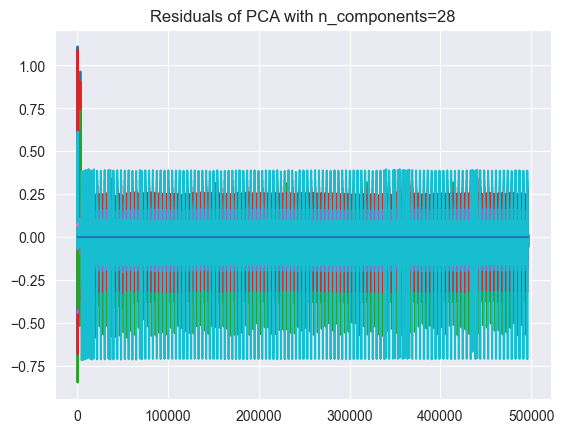

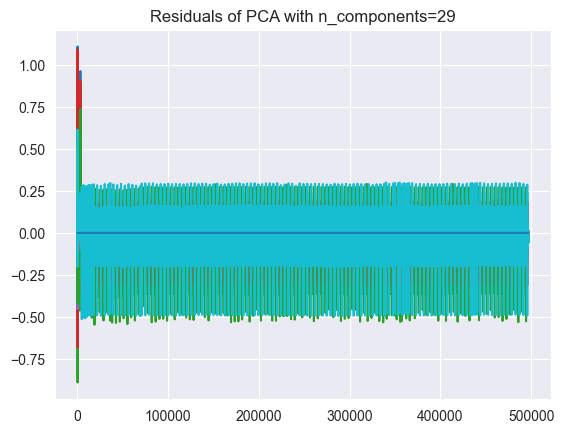

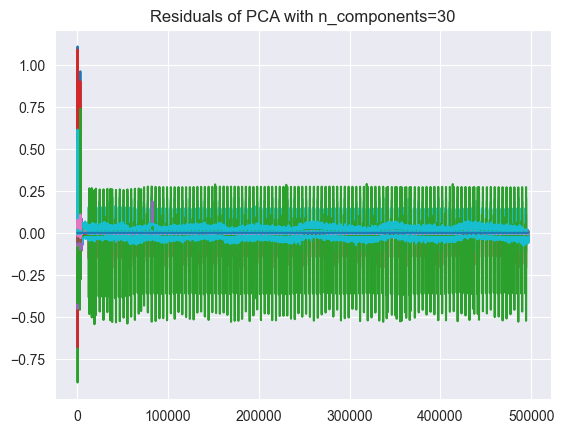

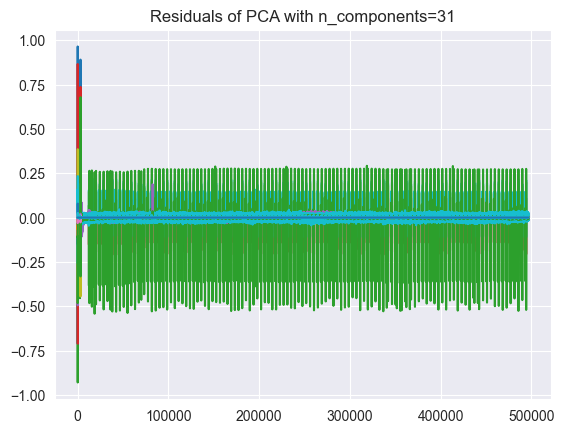

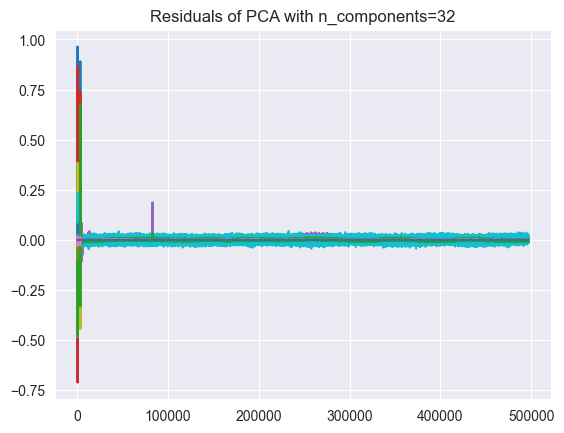

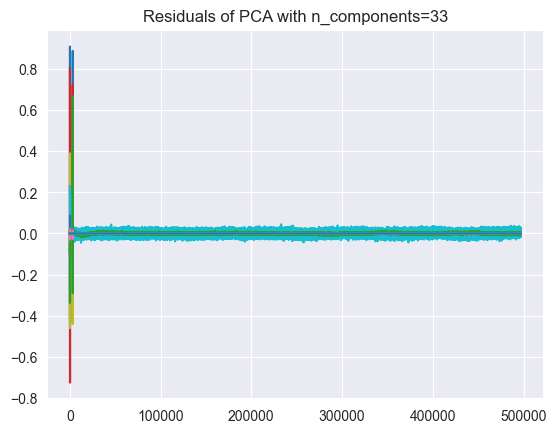

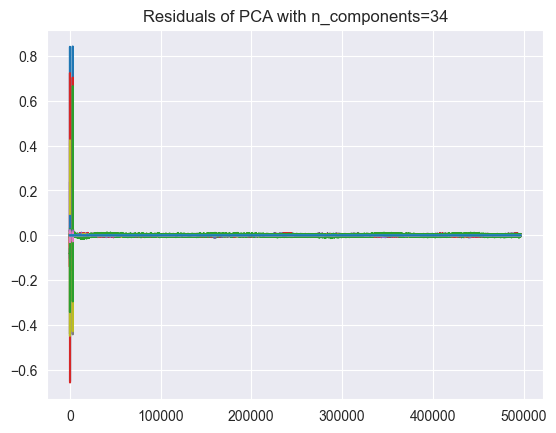

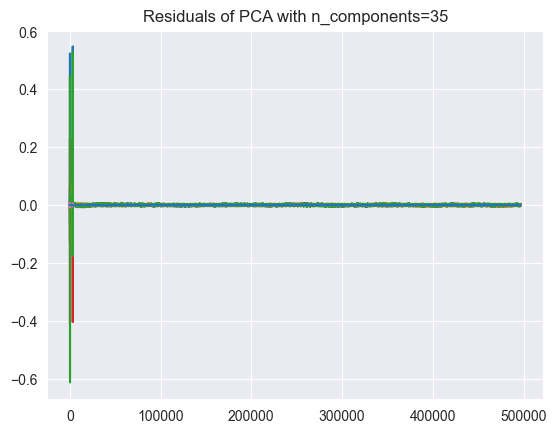

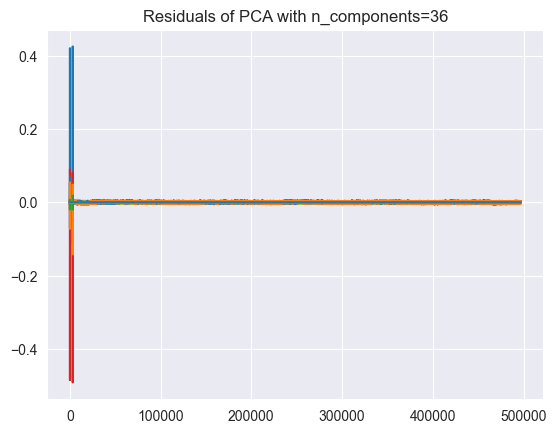

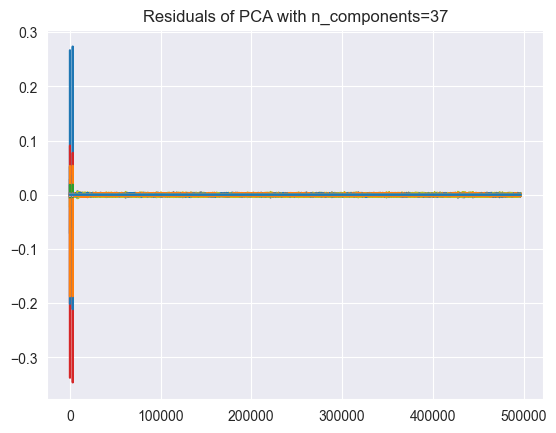

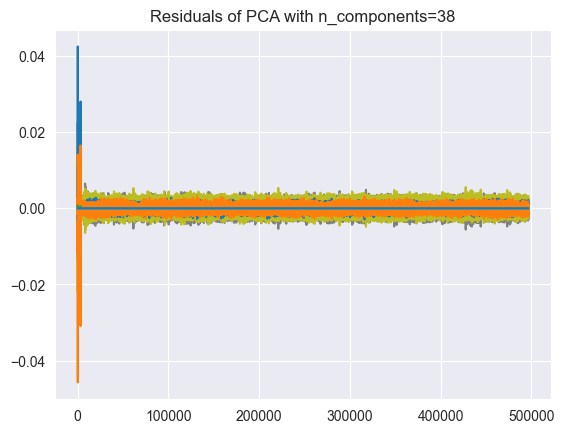

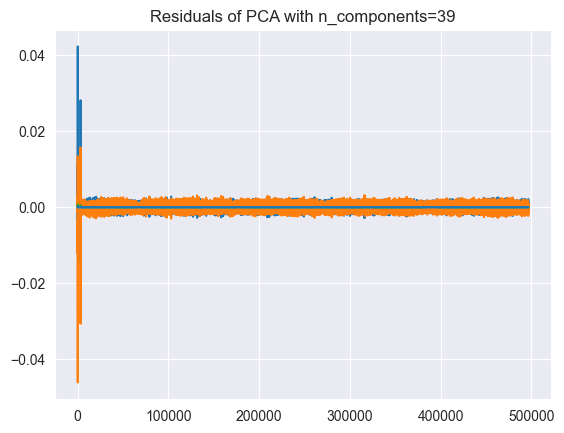

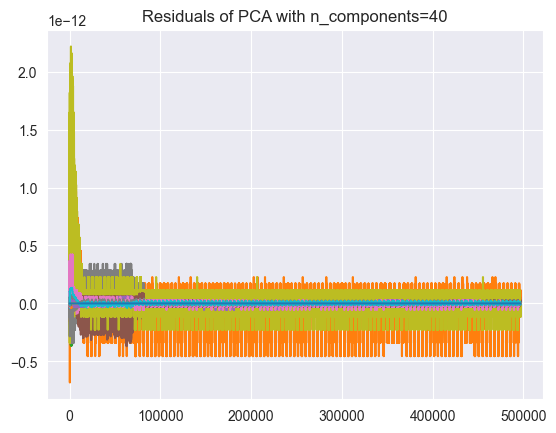

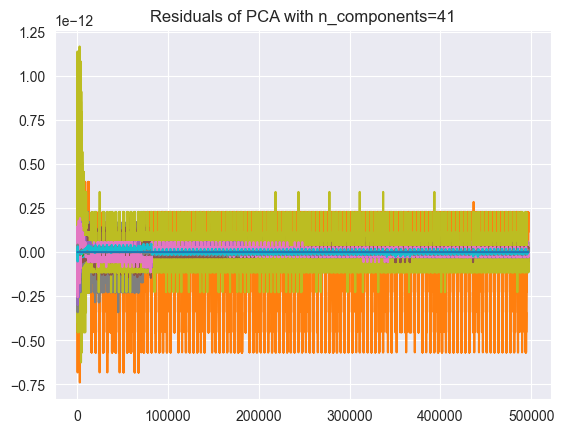

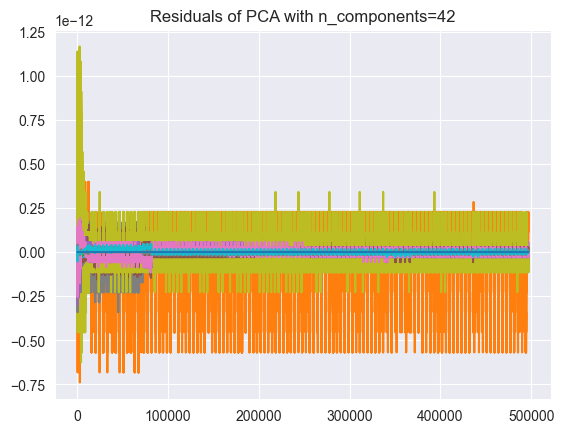

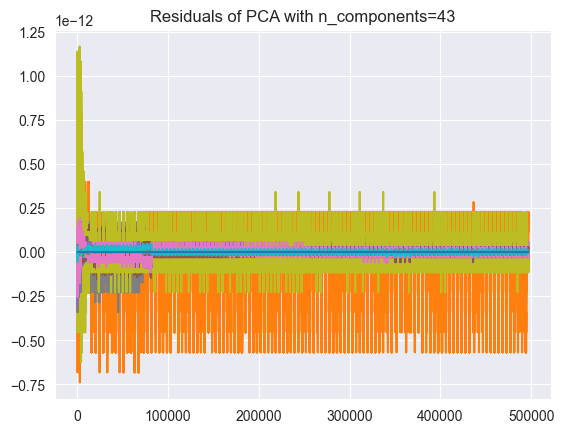

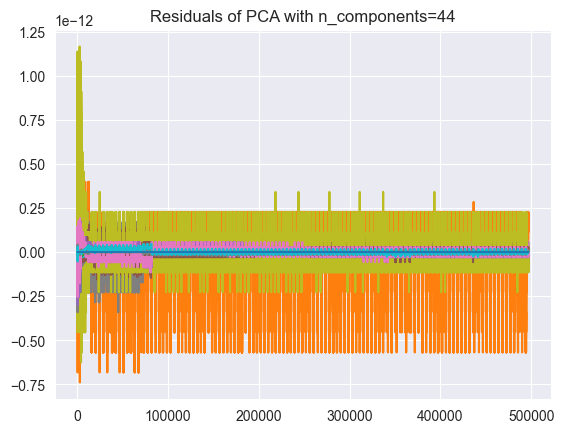

Unexpected exception formatting exception. Falling back to standard exception
Error in callback <function _draw_all_if_interactive at 0x000001F86C890F40> (for post_execute):


Traceback (most recent call last):
  File "C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\micha\AppData\Local\Temp\ipykernel_21128\2412776456.py", line 1, in <module>
    plot_pca_residuals(residuals, start_index=0)
  File "C:\Users\micha\AppData\Local\Temp\ipykernel_21128\364812388.py", line 17, in plot_pca_residuals
    plt.plot(x, residual[residual_column][start_index:], label=residual)
  File "C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\pyplot.py", line 2812, in plot
    return gca().plot(
           ^^^^^^^^^^^
  File "C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py", line 1688, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\micha\AppData\Local\P

MemoryError: In RendererAgg: Out of memory

MemoryError: In RendererAgg: Out of memory

<Figure size 640x480 with 1 Axes>

In [169]:
plot_pca_residuals(residuals, start_index=0)

In [ ]:
# plot_pca_residuals(residuals, start_index=50000)

Analyzing the residuals in the test and validation sets.

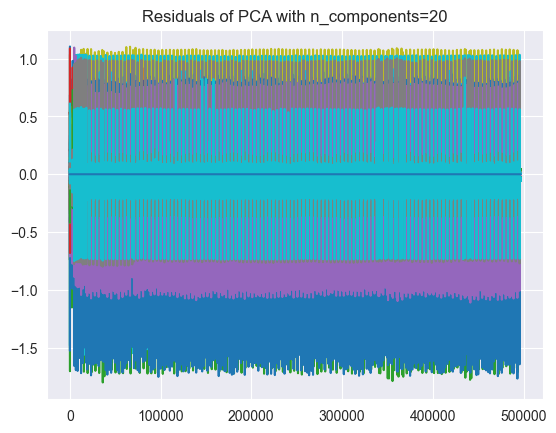

In [136]:
final_components = 20

final_pca = PCA(n_components=final_components)
final_pca.fit(relevant_train_data_df)
train_data_pca = final_pca.transform(relevant_train_data_df)
# Calculate residuals
residuals = relevant_train_data_df - final_pca.inverse_transform(train_data_pca)
plot_pca_residuals([residuals], components=[final_components], start_index=0)

Plotting residuals from the test set.

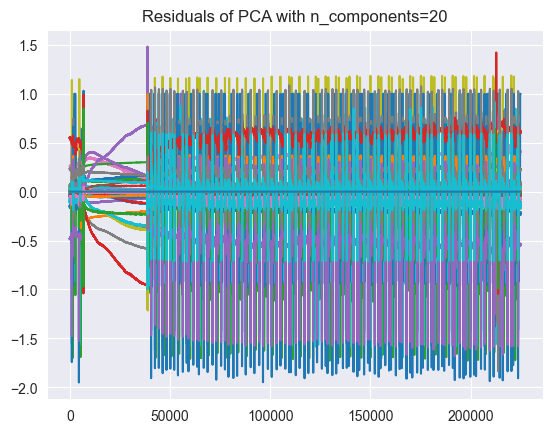

In [145]:
relevant_test_data_df = test_data_df.iloc[:, 1:]

test_data_pca = final_pca.transform(relevant_test_data_df)
# Calculate residuals
residuals =relevant_test_data_df - final_pca.inverse_transform(test_data_pca)
plot_pca_residuals([residuals], components=[final_components], start_index=0)

Plotting residuals from the validation dataset and marking anomalies (red dashed vertical lines). As can be seen, some anomalies are properly detected.

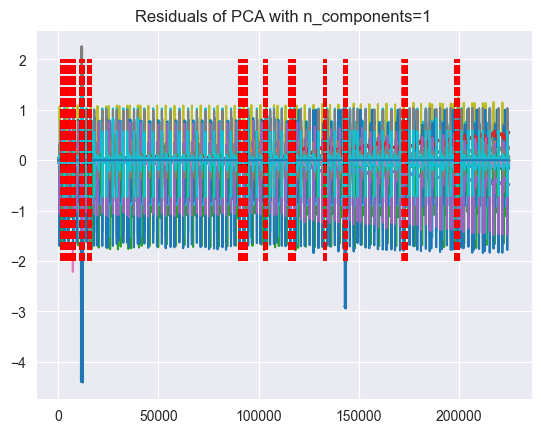

In [146]:
relevant_validation_data_df = val_data_df.iloc[:, 1:-1]
validation_data_pca = final_pca.transform(relevant_validation_data_df)
# Calculate residuals
validation_residuals = relevant_validation_data_df - final_pca.inverse_transform(validation_data_pca)
# Get indices of anomalies
anomaly_indices = np.where(val_data_df['Label'].to_numpy() == 1)[0]
plot_pca_residuals([validation_residuals], start_index=0, true_labels=anomaly_indices)

Defining the allowed range for each of the signal which is set to be (1.5 * smallest_signal_residual, 1.5 * largest_signal_residual) to provide some safety margin. If the residual of a signal is out of this range, then the signal is considered an anomaly.

In [163]:
def calculate_thresholds(residuals, range_multiplier=1.5):
    thresholds = {}
    for signal in residuals.columns:
        thresholds[signal] = (residuals[signal].min() * range_multiplier, residuals[signal].max() * range_multiplier)
    return thresholds

train_residuals = final_pca.inverse_transform(final_pca.transform(relevant_train_data_df)) - relevant_train_data_df
thresholds = calculate_thresholds(train_residuals, range_multiplier=4)

In [148]:
print(validation_residuals)

          FIT101    LIT101     MV101      P101          P102    AIT201  \
Id                                                                       
0      -0.016565  0.000005  0.041500  0.003082 -4.440892e-16 -0.000152   
1      -0.014150  0.000004  0.035608  0.003090 -4.440892e-16 -0.000084   
2      -0.008425  0.000003  0.021054  0.003706 -4.440892e-16 -0.000075   
3      -0.002302  0.000002  0.005333  0.003508 -4.440892e-16 -0.000101   
4       0.002562  0.000002 -0.007328  0.003044 -4.440892e-16 -0.000146   
...          ...       ...       ...       ...           ...       ...   
224954 -0.016247  0.000021  0.000583 -0.031526  8.881784e-15 -0.007373   
224955 -0.012993  0.000020 -0.007687 -0.031586  8.881784e-15 -0.007366   
224956 -0.012631  0.000021 -0.008583 -0.031596  8.881784e-15 -0.007375   
224957 -0.016031  0.000022 -0.000709 -0.031780  8.881784e-15 -0.007532   
224958 -0.018235  0.000022  0.004953 -0.031709  8.881784e-15 -0.007532   

          AIT202    AIT203    FIT201 

In [164]:
def find_anomalies_in_residuals(residuals, thresholds):
    """
    Returns the set containing indices of anomalies in the residuals.
    """
    anomalies_indices = set()
    for signal in residuals.columns:
        allowed_range = thresholds[signal]
        lower_bound = residuals[signal].lt(allowed_range[0])
        upper_bound = residuals[signal].gt(allowed_range[1])
        anomalies = lower_bound | upper_bound
        current_anomaly_indices = set(np.arange(len(residuals.index))[anomalies])
        anomalies_indices = anomalies_indices.union(current_anomaly_indices)
    return anomalies_indices

predicted_anomalies = list(find_anomalies_in_residuals(validation_residuals, thresholds))


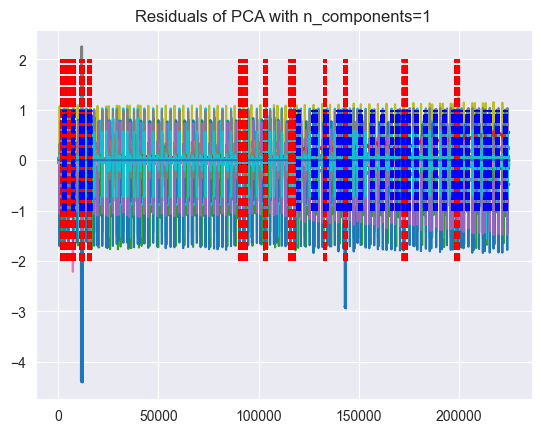

In [166]:
plot_pca_residuals([validation_residuals], start_index=0, true_labels=anomaly_indices, predicted_labels=predicted_anomalies)

Calculate metrics for the PCA model.

In [152]:
# Calculate the number of true positives, false positives, true negatives and false negatives
def calculate_statistics(predicted_anomalies, true_anomalies):
    true_positives = len(set(predicted_anomalies).intersection(set(true_anomalies)))
    false_positives = len(set(predicted_anomalies).difference(set(true_anomalies)))
    true_negatives = len(set(np.arange(len(validation_residuals.index))).difference(set(predicted_anomalies).union(set(true_anomalies))))
    false_negatives = len(set(true_anomalies).difference(set(predicted_anomalies)))
    return true_positives, false_positives, true_negatives, false_negatives

tp, fp, tn, fn = calculate_statistics(predicted_anomalies, anomaly_indices)
print(f"True positives: {tp}, False positives: {fp}, True negatives: {tn}, False negatives: {fn}")

def calculate_metrics(tp, fp, tn, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    return accuracy, precision, recall, f1_score

accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 score: {f1_score}")


True positives: 3218, False positives: 12567, True negatives: 201356, False negatives: 7818
Accuracy: 0.909383487657751, Precision: 0.20386442825467216, Recall: 0.2915911562160203, F1 score: 0.23996122441370568


Analyze several thresholds. Turns out that multiplying the max and min values in the train set by 4 gives the best results.

In [159]:
def analyze_thresholds(residuals, true_anomalies, thresholds, range_multipliers):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    for i, threshold in enumerate(thresholds):
        predicted_anomalies = list(find_anomalies_in_residuals(residuals, threshold))
        tp, fp, tn, fn = calculate_statistics(predicted_anomalies, true_anomalies)
        accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        print(f"Threshold multiplier: {range_multipliers[i]}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 score: {f1_score}\n")
    return accuracies, precisions, recalls, f1_scores

threshold_multipliers = np.arange(1, 10, 0.5)
thresholds = [calculate_thresholds(train_residuals, range_multiplier=multiplier) for multiplier in threshold_multipliers]
accuracies, precisions, recalls, f1_scores = analyze_thresholds(validation_residuals, anomaly_indices, thresholds, threshold_multipliers)

Threshold multiplier: 1.0, Accuracy: 0.5391649144955303, Precision: 0.06380494052720304, Recall: 0.6138999637549837, F1 score: 0.11559559457084602

Threshold multiplier: 1.5, Accuracy: 0.64376619739597, Precision: 0.07603013718801384, Recall: 0.5614353026458861, F1 score: 0.13392413271371445

Threshold multiplier: 2.0, Accuracy: 0.7085824528025106, Precision: 0.08700592361416214, Recall: 0.5203878216745198, F1 score: 0.14908557558765884

Threshold multiplier: 2.5, Accuracy: 0.7768437804222103, Precision: 0.098595879881111, Recall: 0.4358463211308445, F1 score: 0.1608130923923037

Threshold multiplier: 3.0, Accuracy: 0.852088602812068, Precision: 0.14795466058763931, Recall: 0.42343240304458135, F1 score: 0.21928671984983572

Threshold multiplier: 3.5, Accuracy: 0.9031379051293791, Precision: 0.23187394036102524, Recall: 0.42134831460674155, F1 score: 0.2991315535541975

Threshold multiplier: 4.0, Accuracy: 0.9149133842166794, Precision: 0.2643210235533585, Recall: 0.411833997825299, F1

### 3b. Analysis and answers to the questions

## 4. ARMA task – 1/2 A4 - Individual

### 4a. Print relevant plots and/or metrics to determine the parameters.

### 4b. Plots to study the detected anomalies

### 4c. Analysis and answers to the questions